#Chinese Instrument Classification using MFCC extraction
##### Author: Axel Rooth
##### Course: Music Informatics DT2470

This project is based on the paper with the accompanied dataset which the author provides. https://arxiv.org/pdf/2108.08470v2.pdf. The data contains 11 chinese instruments with 5 audio files each. The project's aim was to achieve a higher performance than existing methods. This was achieved using the Random Forest algorithm. 

## Preparation

In [ ]:
!pip install pydub

In [ ]:
!pip install gdown

In [ ]:
!gdown https://drive.google.com/uc?id=1rfbXpkYEUGw5h_CZJtC7eayYemeFMzij

In [ ]:
!sudo apt-get install p7zip-full

In [ ]:
!7z x "ChMusic.7z"

## Libraries

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
import numpy as np 
from pydub import AudioSegment
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, recall_score, precision_score
from mlxtend.plotting import plot_confusion_matrix
import soundfile as sf
import librosa
import librosa.display
import scipy
import os
import pickle
import pdb
import tensorflow as tf
import scipy.io 
import scipy.signal
from skimage.transform import resize
import cv2
import pickle as pkl
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import trange
from sklearn.metrics import accuracy_score
from IPython.display import Audio, display, Image


## Theory

### MFCC extraction of audio

The steps to extract the MFCC are:

1. Break the audio signal into overlapping frames
2. Compute the Short-Time Fourier Transform on the frames

$STFT\{x[n]\}(m,\omega)\equiv X(m,\omega) = \sum_{n=-\infty}^{\infty} x[n]w[n-m]e^{-i \omega n}$

3. Apply the mel filterbank to the power spectra, sum the energy in each filter. Where the frequencies are in th mel-scale. $m = 2595 \log_{10}\left(1 + \frac{f}{700}\right)$
4. Take the logarithm of all filterbank energies.
5. Take the **Discrete Cosine Transform (DCT)** of the log filterbank energies. In this case DCT-11:

$X_k =
 \sum_{n=0}^{N-1} x_n \cos \left[\, \tfrac{\,\pi\,}{N} \left( n + \frac{1}{2} \right) k \, \right]
 \qquad \text{ for } ~ k = 0,\ \dots\ N-1 ~.$

### Result metric

$\text{Accuracy}=\frac{\text{correct classifications}}{\text{all classifications}}$

$\text{Precision}=\frac{|\{\text{relevant documents}\}\cap\{\text{retrieved documents}\}|}{|\{\text{retrieved documents}\}|}$

$\text{Recall}=\frac{|\{\text{relevant documents}\}\cap\{\text{retrieved documents}\}|}{|\{\text{relevant documents}\}|}$

$F_1 = \frac{2}{\mathrm{recall}^{-1} + \mathrm{precision}^{-1}} = 2 \frac{\mathrm{precision} \cdot \mathrm{recall}}{\mathrm{precision} + \mathrm{recall}} = \frac{2\mathrm{tp}}{2\mathrm{tp} + \mathrm{fp} + \mathrm{fn}} $

## Data Preperation and Collection

In [ ]:
def data_retriever(feature_extractor, nmfcc, music_path = "ChMusic/Musics"):
  target_clip_length = 5 
  filter=[".wav"]
  music_list = []
  traindata = []
  testdata = []

  for maindir, subdir, file_name_list in os.walk(music_path):
    for filename in file_name_list:
        apath = os.path.join(maindir, filename)
        ext = os.path.splitext(apath)[1]  
        if ext in filter:
            music_list.append(apath)
            music = AudioSegment.from_wav(apath)
            samplerate = music.frame_rate
            clip_number = int(music.duration_seconds//target_clip_length)
            for k in range(clip_number):
                music[k*target_clip_length*1000:(k+1)*target_clip_length*1000].export("./tem_clip.wav", format="wav")
                x, sr = librosa.load("./tem_clip.wav")

                if feature_extractor == librosa.feature.mfcc:
                  feature_tem = feature_extractor(x, sr, n_mfcc=nmfcc, dct_type=2)
                elif feature_extractor == librosa.stft:
          
                  X_libs = librosa.stft(x, n_fft= int(25*sr/1000), hop_length=int(10*sr/1000))
                  X_temp = np.zeros((X_libs.shape))
                  for j in range(len(X_libs)):
                    X_temp[j] = scipy.fftpack.dct(np.log(np.abs(X_libs[j])**2/X_libs.shape[0]))
                  feature_tem = X_temp
                else:
                  feature_tem = feature_extractor(x, sr, n_chroma=20, bins_per_octave=60)

                if apath[-5] == '5':
                    strlist = apath.split('/')

                    testdata.append([feature_tem,strlist[-1][:strlist[-1].find(".")]])
                else:
                    strlist = apath.split('/')

                    traindata.append([feature_tem,strlist[-1][:strlist[-1].find(".")]])

  return traindata, testdata

In [ ]:
class MusicDataset(torch.utils.data.Dataset):
  def __init__(self, dataX, dataY):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    self.dataX = torch.tensor(dataX, dtype = torch.float32).float().to(device)
    self.dataY = torch.from_numpy(dataY).to(device)

  def __len__(self):
    return len(self.dataY)

  def __getitem__(self, idx):
    return self.dataX[idx], self.dataY[idx]

In [ ]:
def dataloader(traindata, testdata):
  train_X = []
  train_Y = []
  test_X = []
  test_Y = []
  for i in traindata:
      train_X.append(i[0])
      train_Y.append(int(i[1])-1)
  for i in testdata:
      test_X.append(i[0])
      test_Y.append(int(i[1])-1)
  train_X = np.array(train_X, dtype = "float64")
  train_X = np.expand_dims(train_X, axis=3)
  train_Y = np.array(train_Y)
  test_X = np.array(test_X, dtype = "float64")
  test_X = np.expand_dims(test_X, axis=3)
  test_Y = np.array(test_Y)

  train_dataset = MusicDataset(train_X, train_Y)
  test_dataset = MusicDataset(test_X, test_Y)

  train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle=True)
  test_dataloader = DataLoader(test_dataset, batch_size = 32)

  return train_dataloader, test_dataloader


In [ ]:
traindata_mfcc_20, testdata_mfcc_20 = data_retriever(feature_extractor = librosa.feature.mfcc, nmfcc=20)
traindata_mfcc_30, testdata_mfcc_30 = data_retriever(feature_extractor = librosa.feature.mfcc, nmfcc=30)

In [ ]:
train_dataloader_mfcc, test_dataloader_mfcc = dataloader(traindata_mfcc_20, testdata_mfcc_20)

## Data Presentation

### Audio of 1.1.wav file playing the instrument Erhu

In [ ]:
sound_file = "ChMusic/Musics/1.1.wav"
display(Audio(sound_file))

In [ ]:
instruments = {1: "Erhu",
 2: "Pipa",
 3: "Sanxian",
 4: "Dizi",
 5: "Suona",
 6: "Zhuiqin",
 7: "Zhongruan",
 8: "Liuqin",
 9: "Guzheng",
 10: "Yangqin",
 11: "Sheng"}

for k, v in instruments.items():
  print(f"{k}. {v}")
  display(Image(filename=f'ChMusic/InstrumentsDescription/{k}.jpg',width=80))


In [ ]:
display(Image(filename=f'ChMusic/InstrumentsDescription/MusicsList.png',width=500))

### MFCC image of one part of 1.1.wav audio file with two different number of bands, 20 bands and 20 bands

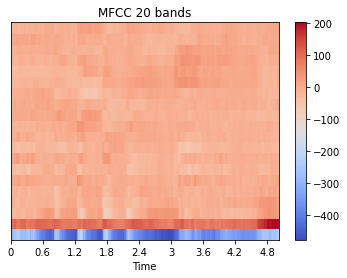

In [ ]:
fig, ax = plt.subplots(nrows=1, sharex=True)
img1 = librosa.display.specshow(traindata_mfcc_20[0][0], x_axis='time')
fig.colorbar(img1, ax=ax)
ax.set(title='MFCC 20 bands')
fig.show()

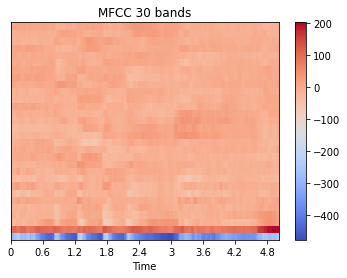

In [ ]:
fig, ax = plt.subplots(nrows=1, sharex=True)
img1 = librosa.display.specshow(traindata_mfcc_30[0][0], x_axis='time')
fig.colorbar(img1, ax=ax)
ax.set(title='MFCC 30 bands')
fig.show()

## ML models and classification

In [ ]:
def classifier(traindata, testdata, model):
  X = []
  Y = []
  for i in traindata:
    for j in range(len(i[0][0,:])):
      X.append(i[0][:,j])
      Y.append(int(i[1]))
  model.fit(np.asarray(X), np.asarray(Y))

  # test model
  correct = 0
  all_clips = 0
  predict = []
  ground = []
  for i in testdata:
      X_test = []
      all_clips += 1
      for j in range(len(i[0][0,:])):
          X_test.append(i[0][:,j])
      clip_result = model.predict(np.asarray(X_test))
      c = Counter(clip_result)
      value, count = c.most_common()[0]
      predict.append(value)
      ground.append(int(i[1]))
      if value == int(i[1]):
          correct += 1
  accuracy = correct/all_clips
  return accuracy, model, ground, predict

###KNN

In [ ]:
def knn_training(traindata, testdata, type_of_data):
  # KNN 
  KNN_model = KNeighborsClassifier(n_neighbors=15)

  accuracy, KNN_model, ground, predict = classifier(traindata, testdata, KNN_model)
  print("Acc", accuracy)
  print("F1", f1_score(ground, predict, average = "macro"))
  print("Recall", recall_score(ground, predict, average = "macro"))
  print("Precision", precision_score(ground, predict, average = "macro"))

  cm  = confusion_matrix(ground, predict, labels= KNN_model.classes_)
  fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(6, 6), cmap=plt.cm.Greens)
  plt.xlabel('Predictions', fontsize=16)
  plt.ylabel('Actuals', fontsize=16)
  #plt.title('Confusion Matrix', fontsize=18)
  plt.imshow(cm)
  plt.savefig(f'KNN_{type_of_data}_ConfusionMatrix.pdf')


Acc 0.9473684210526315
F1 0.9456193267022145
Recall 0.9518814518814519
Precision 0.9466032363358565


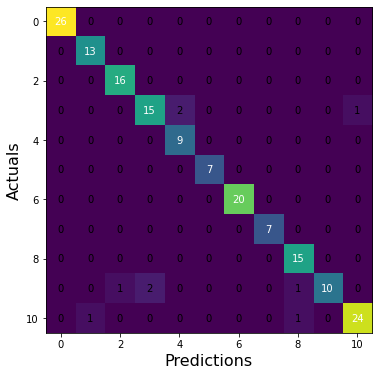

In [ ]:
knn_training(traindata_mfcc_20, testdata_mfcc_20, "mfcc")

###CNN

In [ ]:
class CNNmodel(nn.Module):
  def __init__(self):
    super(CNNmodel, self).__init__()

    self.conv1 = nn.Conv1d(20, 32, kernel_size=3, padding = "same")
    self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding = "same")
    self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding = "same")
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool1d(2,stride=2)
    

    self.layer_output = nn.Sequential(
        nn.Linear(3456 ,128),
        nn.ReLU(),
        nn.Linear(128, 11) 
    )

  def forward(self,input):
    batch_size = input.size()[0]
    input = input.squeeze()
    x = self.conv1(input)
    x = self.relu(x)
    x = self.maxpool(x)
    x = self.conv2(x)
    x = self.relu(x)
    x = self.maxpool(x)
    x = self.conv3(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = x.view(batch_size, -1)
    output = self.layer_output(x)
    return output

In [ ]:
def neural_training(model,model_name ,train_dataloader, test_dataloader,epochs = 15 ):  
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  criterion = nn.CrossEntropyLoss()
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

  for epoch in trange(epochs):
    running_loss = 0.0
    predictions_l = list(); labels_l = list()
    for (inputs, labels) in train_dataloader:
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)

      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      
      predictions = torch.argmax(F.softmax(outputs, dim = -1), dim = -1)
      predictions_l.extend(predictions.cpu())
      labels_l.extend(labels.cpu())
    acc = accuracy_score(labels_l, predictions_l)
    print(f" Loss: {running_loss} Acc: {acc}")

    
  model.eval()
  test_predictions_l = list(); test_labels_l = list()
  with torch.no_grad():
    for batch_idx, (test_inputs, test_labels) in enumerate(test_dataloader):
      dev_outputs = model(test_inputs)
      test_predictions = torch.argmax(F.softmax(dev_outputs, dim = -1), dim = -1)
      test_predictions_l.extend(test_predictions.cpu())
      test_labels_l.extend(test_labels.cpu())

    acc = accuracy_score(test_labels_l, test_predictions_l)
    print(f" Test acc: {acc}")
  
  print("F1", f1_score(test_labels_l, test_predictions_l, average = "macro"))
  print("Recall", recall_score(test_labels_l, test_predictions_l, average = "macro"))
  print("Precision", precision_score(test_labels_l, test_predictions_l, average = "macro"))
  cm  = confusion_matrix(test_labels_l, test_predictions_l, labels= list(range(1,11)))
  fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(6, 6), cmap=plt.cm.Greens)
  plt.xlabel('Predictions', fontsize=16)
  plt.ylabel('Actuals', fontsize=16)
  #plt.title('Confusion Matrix', fontsize=18)
  plt.imshow(cm)
  plt.savefig(f'{model_name}_ConfusionMatrix.pdf')
  torch.save(model.state_dict(), f"{model_name}.pt")




  4%|▍         | 1/25 [00:00<00:21,  1.10it/s]

 Loss: 50.37475103139877 Acc: 0.424390243902439


  8%|▊         | 2/25 [00:01<00:18,  1.27it/s]

 Loss: 12.75295677781105 Acc: 0.8341463414634146


 12%|█▏        | 3/25 [00:02<00:16,  1.35it/s]

 Loss: 6.681726861745119 Acc: 0.9182926829268293


 16%|█▌        | 4/25 [00:02<00:15,  1.39it/s]

 Loss: 3.4344998616725206 Acc: 0.9646341463414634


 20%|██        | 5/25 [00:03<00:14,  1.40it/s]

 Loss: 2.125105016864836 Acc: 0.975609756097561


 24%|██▍       | 6/25 [00:04<00:13,  1.43it/s]

 Loss: 0.5855235713534057 Acc: 0.9939024390243902


 28%|██▊       | 7/25 [00:05<00:12,  1.43it/s]

 Loss: 0.20241849380545318 Acc: 1.0


 32%|███▏      | 8/25 [00:05<00:11,  1.44it/s]

 Loss: 0.06731245253467932 Acc: 1.0


 36%|███▌      | 9/25 [00:06<00:11,  1.45it/s]

 Loss: 0.028504535410320386 Acc: 1.0


 40%|████      | 10/25 [00:07<00:10,  1.45it/s]

 Loss: 0.019377037009689957 Acc: 1.0


 44%|████▍     | 11/25 [00:07<00:09,  1.44it/s]

 Loss: 0.014746224391274154 Acc: 1.0


 48%|████▊     | 12/25 [00:08<00:08,  1.45it/s]

 Loss: 0.011796978680649772 Acc: 1.0


 52%|█████▏    | 13/25 [00:09<00:08,  1.45it/s]

 Loss: 0.009318787313532084 Acc: 1.0


 56%|█████▌    | 14/25 [00:09<00:07,  1.45it/s]

 Loss: 0.007695840373344254 Acc: 1.0


 60%|██████    | 15/25 [00:10<00:06,  1.46it/s]

 Loss: 0.006325700356683228 Acc: 1.0


 64%|██████▍   | 16/25 [00:11<00:06,  1.46it/s]

 Loss: 0.005584160462603904 Acc: 1.0


 68%|██████▊   | 17/25 [00:11<00:05,  1.46it/s]

 Loss: 0.00475780093256617 Acc: 1.0


 72%|███████▏  | 18/25 [00:13<00:06,  1.16it/s]

 Loss: 0.004019654872536194 Acc: 1.0


 76%|███████▌  | 19/25 [00:13<00:04,  1.23it/s]

 Loss: 0.003622965141403256 Acc: 1.0


 80%|████████  | 20/25 [00:14<00:03,  1.28it/s]

 Loss: 0.003129317716229707 Acc: 1.0


 84%|████████▍ | 21/25 [00:15<00:03,  1.33it/s]

 Loss: 0.0032078594995255116 Acc: 1.0


 88%|████████▊ | 22/25 [00:15<00:02,  1.36it/s]

 Loss: 0.002513822626497131 Acc: 1.0


 92%|█████████▏| 23/25 [00:16<00:01,  1.39it/s]

 Loss: 0.0023493245698773535 Acc: 1.0


 96%|█████████▌| 24/25 [00:17<00:00,  1.40it/s]

 Loss: 0.002096698908644612 Acc: 1.0


100%|██████████| 25/25 [00:18<00:00,  1.38it/s]

 Loss: 0.001953240600414574 Acc: 1.0
 Test acc: 0.8596491228070176
F1 0.8408135164641181
Recall 0.8669330669330669
Precision 0.8429769304769305


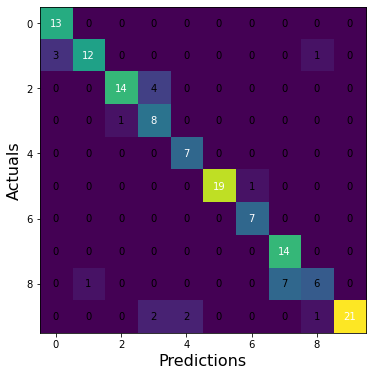

In [ ]:
neural_training(CNNmodel(), "CNN_mfcc", train_dataloader_mfcc, test_dataloader_mfcc, epochs = 25)

### Random Forest (Own model)

Acc 0.9473684210526315
F1 0.952917873372419
Recall 0.9533244533244535
Precision 0.9577922077922079


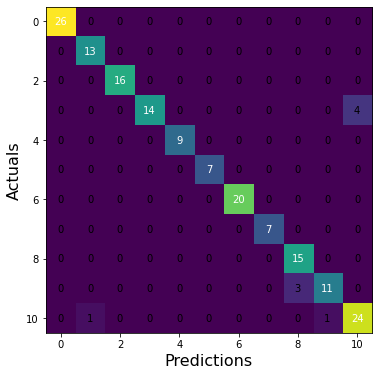

In [ ]:
model = RandomForestClassifier(n_estimators=100)

accuracy, model, ground, predict = classifier(traindata_mfcc_30, testdata_mfcc_30, model)
print("Acc", accuracy)
print("F1", f1_score(ground, predict, average = "macro"))
print("Recall", recall_score(ground, predict, average = "macro"))
print("Precision", precision_score(ground, predict, average = "macro"))

cm  = confusion_matrix(ground, predict, labels= model.classes_)
fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=16)
plt.ylabel('Actuals', fontsize=16)
#plt.title('Confusion Matrix', fontsize=18)
plt.imshow(cm)
plt.savefig('RF_ConfusionMatrix.pdf')

## Results

|             | KNN         | CNN        | Random Forest |
| ----------- | ----------- |----------- | -----------   |
| Accuracy    | 0.947       | 0.860      | 0.947         |
| F1          | 0.946       | 0.841      | 0.953         |
| Recall      | 0.952       | 0.867      | 0.953         |
| Precision   | 0.947        | 0.843      | 0.958         |

The result suggest that the new implemented model of a Random Forest Classifier beat Gong et al. algorithms of KNN and CNN. Even though the KNN in this case got the same accuracy, the Gong et al.s KNN got a worse score (92.4% accuracy) than my KNN at (94.7%). Furthermore, the RF was better overall with a higher F1 score, Recall and Precision. 

## Discussion and Limitations

In this project, the author showed that the classification of chinese instruments can be improved using 30 bands of MFCCs. During the projects explorative phase, different feature extraction methods were choosen but with much worse accuracy in the end. Therefore, the author only provided the MFCC classification which the authors from the original paper also provided. However, there are some quite important limitations to this project. Firstly, the dataset which has been used is quite small which could indicate that the model is not that greeat at generalize to new data of other songs. The testdata in itself are good but it only accounts for 5 audio files which is very small for machine learning standard. Secondly, if the dataset was larger one the deep learning approach could have been more suited but that remains unclear. In the light of more research that question may be answered. One further acknowledgement is in what aspect this project could impact the music informatics space. The conclusion to this is that because of the small dataset the contribution is quite small. For further research one could aim to make a model which classifies audio with multiple instruments or a model which can classify all known instruments that exists both in western music, eastern and the rest of the world. Of course an ambitious feat but nonetheless important for the music informatic research space to extend wider to new grounds.